*CPSC 381/581: Introduction to Machine Learning Final Project* \
*Project Name: Determining the Relationship of Region, Income, and Carbon Emission Rates to Average Country Temperature* \
Group Members: Deja Dunlap, Fiza Shakeel, Nicole Tian

**Step 1: Importing the Packages**

In [1]:
# Import Packages
%pip install scikit-learn==1.1

  Using cached scikit-learn-1.1.0.tar.gz (6.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [66 lines of output]
      Partial import of sklearn during the build process.
      setup.py:128: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/distutils_status_migration.html
      
      
        from numpy.distutils.command.build_ext import build_ext  # noqa
      INFO: No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
      Traceback (most recent call last):
        File "c:\Users\dejad\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_proces

In [2]:
import numpy as np
import sklearn.metrics as skmetrics
from sklearn.linear_model import LinearRegression as LinearRegressionSciKit
import warnings
import pandas as pd
from matplotlib import pyplot as plt

warnings.filterwarnings(action='ignore')
np.random.seed = 1

**Step 2: Cleaning the Data**

In [3]:
# Reading in the datasets
temp_by_year_and_country = pd.read_csv('data/temp_by_year_and_country.csv', delimiter=',')
carbon_emission_by_country = pd.read_csv('data/co_emissions_per_capita.csv', delimiter=',')

# changing carbon emission csv to match formatting of the temp by year csv
carbon_emission_by_country = carbon_emission_by_country.pivot_table('Annual CO₂ emissions (per capita)', ['Code', 'Entity'], 'Year').reset_index()
years = ['Country', 'Code', (x for x in range(1960, 2022))]

# changing the names of the columns so they match for merging
carbon_emission_by_country.rename(columns = {'Entity':'Country'}, inplace = True)
temp_by_year_and_country.rename(columns = {'ISO3':'Code'}, inplace = True)

# recode subregions 
subregions = temp_by_year_and_country['Sub-Region'].unique()
subregion_to_code = {subregion: idx for idx, subregion in enumerate(subregions)}
code_to_subregion = {idx: subregion for subregion, idx in subregion_to_code.items()}

# recode income groups
income_groups = temp_by_year_and_country['Income Group'].unique()
incomegroup_to_code = {income_groups: idx for idx, income_groups in enumerate(income_groups)}
code_to_income_group= {idx: income_group for income_group, idx in incomegroup_to_code.items()}

# add encoded subregion and income group
temp_by_year_and_country['Subregion_Code'] = temp_by_year_and_country['Sub-Region'].map(subregion_to_code)
temp_by_year_and_country['Income_Group_Code'] = temp_by_year_and_country['Income Group'].map(incomegroup_to_code)

# merging datasets for dataset three
dataset_3 = pd.merge(carbon_emission_by_country, temp_by_year_and_country, on=['Country', 'Code'],  how='inner')

# creating the datasets for all three test
years = [x for x in range(1961,2023)]
years_str = [str(x) for x in range(1961,2023)]


dataset_1 = temp_by_year_and_country[['Subregion_Code'] + years_str]
dataset_2 = temp_by_year_and_country[['Subregion_Code', 'Income_Group_Code'] + years_str]
dataset_3 = dataset_3[['Subregion_Code', 'Income_Group_Code'] + years + years_str]

dataset_3.rename(columns=lambda x: str(x) + "_1" if isinstance(x, int) else x, inplace=True)


# creating test and training datasets from each of the datasets
dataset_1_data = dataset_1.drop(columns=['2022'])
dataset_1_target = dataset_1['2022']

dataset_2_data = dataset_2.drop(columns=['2022'])
dataset_2_target = dataset_2['2022']

dataset_3_data = dataset_3.drop(columns=['2022'])
dataset_3_target = dataset_3['2022']

dataset_3_data = dataset_3_data.dropna() 


**Step 3: Creating the Model**

In [4]:
'''
Implementation of linear regression by directly solving normal equation or pseudo-inverse
'''
class LinearRegression(object):

    def __init__(self):
        # Define private variables
        self.__weights = None

    def __fit_normal_equation(self, X, y):
        '''
        Fits the model to x and y via normal equation

        Arg(s):
            X : numpy
                N x d feature vector
            y : numpy
                N x 1 ground-truth label
        '''


        # Implement normal equation: (x^T X) ^ -1 X^T y

        # (x^T X)
        XT_X = np.matmul(X.T, X)
        # (x^T X) -1
        XT_X_inv = np.linalg.inv(XT_X)
        # (x^T X) ^ -1 X^T y
        self.__weights = np.matmul(np.matmul(XT_X_inv, X.T), y)


    def __fit_pseudoinverse(self, X, y):
        '''
        Fits the model to x and y via pseudo-inverse

        Arg(s):
            X : numpy
                N x d feature vector
            y : numpy
                N x 1 ground-truth label
        '''
        self.__weights = None

        # Use SVD to get U, S, VT
        # Take reciprocal of S (to get S+) and then we want to swap U, VT (with their transpose)
        # Multiply V, S+ and UT together to get X+
        U, S, VT = np.linalg.svd(X)

        # Convert S from vector of numbers to S matrix
        S_diag = np.diag(1.0 / S)
        padding = np.zeros([U.shape[0] - S.shape[0], S.shape[0]])

        # calculating the pseudo S
        S_pseudo = np.concatenate([S_diag, padding], axis=0)

        # Take transpose of psuedo S
        S_pseudo = S_pseudo.T

        # VT.T * S_pseudo * U.T
        X_pseudo = np.matmul(np.matmul(VT.T, S_pseudo), U.T)

        # w+ = X+ y
        self.__weights = np.matmul(X_pseudo, y)

    def fit(self, x, y, solver='normal_equation'):
        '''
        Fits the model to x and y by solving the ordinary least squares
        using normal equation or pseudoinverse (SVD)

        Arg(s):
            x : numpy[float32]
                d x N feature vector
            y : numpy[float32]
                1 x N ground-truth label
            solver : str
                solver types: normal_equation, pseudoinverse
        '''
        # transposing data to match specifications of other methods
        X = x.T
        y = y.T

        # fits the data by whichever solver we pass in - for our purposes we'll only be using the normal equation
        if solver == 'normal_equation':
            self.__fit_normal_equation(X, y)
        elif solver == 'pseudoinverse':
            self.__fit_pseudoinverse(X, y)
        else:
          raise ValueError('Unsupported solver: {}'.format(solver))

    def predict(self, x):
        '''
        Predicts the real value for each feature vector x

        Arg(s):
            x : numpy[float32]
                d x N feature vector
        Returns:
            numpy[float32] : d x 1 real value vector (\hat{y})
        '''
        # \hat y = w.T x
        return np.matmul(self.__weights.T, x)

    def __score_r_squared(self, y_hat, y):
        '''
        Measures the r-squared score from groundtruth y

        Args:
            y_hat : numpy[float32]
                1 x N predictions
            y : numpy[float32]
                1 x N ground-truth label

        Returns:
            float : r-squared score
        '''

        # r-squared 
        mean = 0.0
        for val in y:
          mean += val
        mean /= len(y)

        # u = \sum (X - X_hat)^2
        u = 0.0
        for i, (y_1, y_2) in enumerate(zip(y_hat, y)):
          u += pow((y_1 - y_2), 2)

        # v = \sum (X - X_bar)^2
        v = 0.0
        for sample in y:
          v += pow((sample - mean), 2)

        # r-squared 1 - (u/v)
        r_squared = 1 - (u/v)

        return r_squared

    def __score_mean_squared_error(self, y_hat, y):
        '''
        Measures the mean squared error (distance) from groundtruth y

        Arg(s):
            y_hat : numpy[float32]
                1 x N predictions
            y : numpy[float32]
                1 x N ground-truth label

        Returns:
            float : mean squared error (mse)
        '''

        # mean-squared-error = \sum (X - X_bar)^2
        sum = 0.0
        for i, (y_1, y_2) in enumerate(zip(y_hat, y)):
          sum += pow((y_1 - y_2), 2)

        mean_squared_error = float(sum / len(y_hat))

        return mean_squared_error

    def score(self, x, y, scoring_func='r_squared'):
        '''
        Predicts real values from x and measures the mean squared error (distance)
        or r-squared from groundtruth y

        Arg(s):
            x : numpy[float32]
                d x N feature vector
            y : numpy[float32]
                1 x N ground-truth label
            scoring_func : str
                scoring function: r_squared, mean_squared_error

        Returns:
            float : mean squared error (mse)
        '''
        # makes predictions of the data
        predictions = self.predict(x)

        # calculate error by whichever method we pass in
        if scoring_func == 'r_squared':
            return self.__score_r_squared(predictions, y)
        elif scoring_func == 'mean_squared_error':
            return self.__score_mean_squared_error(predictions, y)
        else:
            raise ValueError("Unsupported scoring functions")

**Step 4: Training and Testing the Models**

In [5]:
def k_fold_indices(data, k):
    '''
    Predicts real values from x and measures the mean squared error (distance) or r-squared from groundtruth y

    Arg(s):
        x : numpy[float32]
            N x d feature vector
        k : int
            number of k folds to create

    Returns:
        x : numpy[float32]
                k x (N / k) matrix of indices for the folds
    '''
    # calculating how big each fold should be
    fold_size = len(data) // k

    # shuffling the indices
    indices = np.random.permutation(data.shape[0])
    folds = []

    for i in range(k):
        # splits the dataset up into test and train indices
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        # adds indices to the list
        folds.append((train_indices, test_indices))
    return folds

In [6]:
def plot_results(x, y1, y2, title, xtitle, ytitle, ylabel1, ylabel2):
    '''
    Plots x against y with plot title

    Arg(s):
        x : numpy[float32]
            array of values
        y : numpy[float32]
            array of values
        title : str
            (super)title of plot
        xlabel : str
            label of x axis
        ylabel : str
            label of y axis
    '''

    # Create a 1 x 1 figure
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    # plotting the lines
    plt.plot(x, y1, label = ylabel1, color='b')
    plt.plot(y2, label = ylabel2, color = 'r')

    # setting axis labels
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    
    # legend for graph
    plt.legend()

    # title for graph
    plt.suptitle(title)

    # show
    plt.show()

**Dataset 1: Average Global Temperatures by Country and Year and Country Sub-region**

In [7]:
#Dataset 1: Country average temperatures, country region

# retrieving the previously created datasets for the model
X = dataset_1_data
y = dataset_1_target

# creating k list to test with different k for k-fold testing
k_s = [i for i in range(2, 11)]

# creating arrays to store best r2 and mse across different ks
our_best_r2_data1 = []
scikit_best_r2_data1 = []
our_best_mse_data1 = []
scikit_best_mse_data1 = []

# Testing out different k values
for k in k_s:  

    # create the indices for k fold
    folds = k_fold_indices(X, k)

    # Initializing scikit-learn linear regression model without bias
    model_scikit = LinearRegressionSciKit(fit_intercept=False)

    # Initialize our linear regression model
    model_ours = LinearRegression()

    # creating arrays to store accuracy scores across k-folds
    scikit_r2 = []
    our_r2 = []
    scikit_mse = []
    our_mse = []

    # iterating through each fold, running the both model on each of them
    for fold_idx, (train_indices, test_indices) in enumerate(folds):
        # Iterate through each fold in the x_train and y_train indices to get the training and testing data
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
        # Train the sci_kit model
        model_scikit.fit(X_train, y_train)

        # Make predictions on training set using sci_kit model
        scikit_predictions_train = model_scikit.predict(X_train)

        print('***** Results of scikit-learn linear regression model on dataset 1 *****')

        # get accuracy for scikit model predictions on training set
        score_mse_sciket_train = skmetrics.mean_squared_error(y_train, scikit_predictions_train)
        score_r2_sciket_train = skmetrics.r2_score(y_train, scikit_predictions_train)
        print('Testing set mean squared error: {:.4f}'.format(score_mse_sciket_train))
        print('Testing set r-squared score: {:.4f}'.format(score_r2_sciket_train))

        # Make predictions on testing set using sci_kit model
        scikit_predictions_test = model_scikit.predict(X_test)

        print('***** Results of scikit-learn linear regression model on dataset 1 *****')

        # get accuracy for scikit model predictions on test set
        score_mse_sciket_test = skmetrics.mean_squared_error(y_test, scikit_predictions_test)
        score_r2_sciket_test = skmetrics.r2_score(y_test, scikit_predictions_test)
        print('Testing set mean squared error: {:.4f}'.format(score_mse_sciket_test))
        print('Testing set r-squared score: {:.4f}'.format(score_r2_sciket_test))
        scikit_r2.append(score_r2_sciket_test)
        scikit_mse.append(score_mse_sciket_test)

        # Transposing the data so that it works on our model
        X_train = np.transpose(X_train.values, axes=(1, 0))
        X_test = np.transpose(X_test.values, axes=(1, 0))
        model_ours.fit(X_train, y_train)

        print('***** Results of our linear regression model on dataset 1 *****')

        # make predictions on training set using our model
        our_predictions_train = model_ours.predict(X_train)

        # get accuracy for our model predictions
        score_mse_our_train = model_ours.score(X_train, y_train, scoring_func='mean_squared_error')
        print('Training set mean squared error: {:.4f}'.format(score_mse_our_train))
        score_r2_our_train = model_ours.score(X_train, y_train, scoring_func='r_squared')
        print('Training set r-squared score: {:.4f}'.format(score_r2_our_train))

        # make predictions on testing set using our model
        our_predictions_test = model_ours.predict(X_test)

        # get accuracy on testing set using our model predictions
        score_mse_our_test = model_ours.score(X_test, y_test, scoring_func='mean_squared_error')
        print('Testing set mean squared error: {:.4f}'.format(score_mse_our_test))
        score_r2_our_test = model_ours.score(X_test, y_test, scoring_func='r_squared')
        print('Testing set r-squared score: {:.4f}'.format(score_r2_our_test))
        our_r2.append(score_r2_our_test)
        our_mse.append(score_mse_our_test)

    # appending the best across the folds to our list
    our_best_r2_data1.append(np.max(our_r2))
    scikit_best_r2_data1.append(np.max(scikit_r2))
    our_best_mse_data1.append(np.min(our_mse))
    scikit_best_mse_data1.append(np.min(scikit_mse))

***** Results of scikit-learn linear regression model on dataset 1 *****
Testing set mean squared error: 0.0031
Testing set r-squared score: 0.9930
***** Results of scikit-learn linear regression model on dataset 1 *****
Testing set mean squared error: 0.6882
Testing set r-squared score: -0.6099
***** Results of our linear regression model on dataset 1 *****
Training set mean squared error: 0.0031
Training set r-squared score: 0.9930
Testing set mean squared error: 0.6882
Testing set r-squared score: -0.6099
***** Results of scikit-learn linear regression model on dataset 1 *****
Testing set mean squared error: 0.0040
Testing set r-squared score: 0.9906
***** Results of scikit-learn linear regression model on dataset 1 *****
Testing set mean squared error: 0.2254
Testing set r-squared score: 0.5042
***** Results of our linear regression model on dataset 1 *****
Training set mean squared error: 0.0040
Training set r-squared score: 0.9906
Testing set mean squared error: 0.2254
Testing se

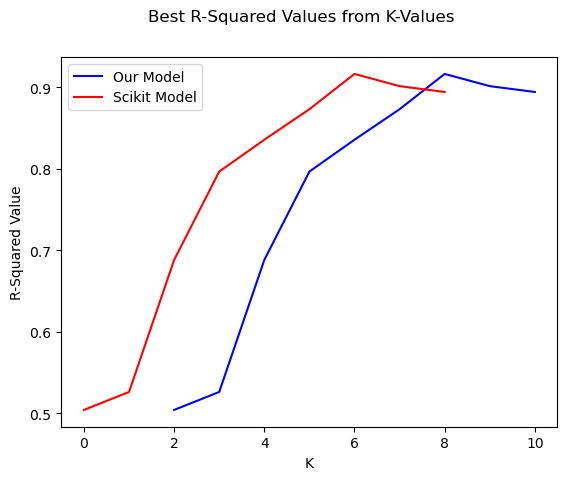

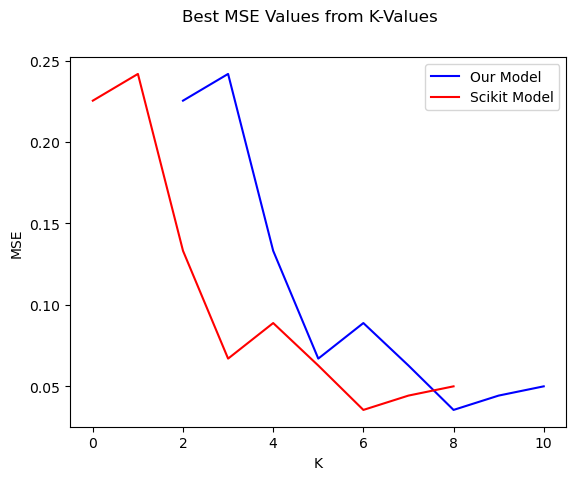

Our max r-squared was: 0.916227650099629
Our min MSE was: 0.035463953741441366
Scikit max r-squared was: 0.9162276500996642
Scikit min MSE was: 0.0354639537414265


In [8]:
# comparing both models r-squared values
plot_results(x = k_s,
            y1 = our_best_r2_data1, 
            y2 = scikit_best_r2_data1, 
            title = "Best R-Squared Values from K-Values", 
            xtitle = "K", 
            ytitle = "R-Squared Value", 
            ylabel1 = "Our Model", 
            ylabel2 = "Scikit Model")

# comparing both models mse values
plot_results(x = k_s,
            y1 = our_best_mse_data1, 
            y2 = scikit_best_mse_data1, 
            title = "Best MSE Values from K-Values", 
            xtitle = "K", 
            ytitle = "MSE", 
            ylabel1 = "Our Model", 
            ylabel2 = "Scikit Model")

# printing out best results from both
print("Our max r-squared was: " + str(max(our_best_r2_data1)))
print("Our min MSE was: " + str(min(our_best_mse_data1)))
print("Scikit max r-squared was: " + str(max(scikit_best_r2_data1)))
print("Scikit min MSE was: " + str(min(scikit_best_mse_data1)))

**Dataset 2: Country average temperatures, country region, country income level**

In [25]:
#Dataset 2: Country average temperatures, country region, country income level
x = dataset_2_data
y = dataset_2_target

scikit_mse_dataset2 = []
scikit_rsquared_dataset2 = []

our_mse_dataset2 = []
our_rsquared_dataset2 = []

for k in range(2, 11):
    folds = k_fold_indices(x, k)
    scikit_mse = []
    scikit_r2 = []
    our_mse = []
    our_r2 = []
    for fold_idx, (train_indices, test_indices) in enumerate(folds):
        # Iterate through each fold in the x_train and y_train indices to get the training and testing data
        x_train, y_train = x.iloc[train_indices], y.iloc[train_indices]
        x_test, y_test = x.iloc[test_indices], y.iloc[test_indices]

        # Trains scikit-learn linear regression model
        model_scikit.fit(x_train, y_train)

        print('***** Results of scikit-learn linear regression model on dataset 2 *****')

        # Test model on training set
        predictions_train = model_scikit.predict(x_train)
        score_mse_train = skmetrics.mean_squared_error(y_train, predictions_train)
        score_r2_train = skmetrics.r2_score(y_train, predictions_train)
        print('Training set mean squared error: {:.4f}'.format(score_mse_train))
        print('Training set r-squared scores: {:.4f}'.format(score_r2_train))

        # Test model on test set
        predictions_test = model_scikit.predict(x_test)
        score_mse_test = skmetrics.mean_squared_error(y_test, predictions_test)
        score_r2_test = skmetrics.r2_score(y_test, predictions_test)
        print('Testing set mean squared error: {:.4f}'.format(score_mse_test))
        print('Testing set r-squared scores: {:.4f}'.format(score_r2_test))

        scikit_mse.append(score_mse_test)
        scikit_r2.append(score_r2_test)
        '''
        Trains and tests our linear regression model using different solvers
        '''

        # Take the transpose of the dataset to match the dimensions used in the model
        x_train = np.transpose(x_train.values, axes=(1, 0))
        x_test = np.transpose(x_test.values, axes=(1, 0))

        # Initialize our linear regression model
        model_ours = LinearRegression()

        print('***** Results of our linear regression model trained on dataset 2 *****')
        # Train model on training set
        model_ours.fit(x_train, y_train)

        # Test model on training set 
        score_mse_train = model_ours.score(x_train, y_train, scoring_func='mean_squared_error')
        score_r2_train = model_ours.score(x_train, y_train, scoring_func='r_squared')
        print('Training set mean squared error: {:.4f}'.format(score_mse_train))
        print('Training set r-squared scores: {:.4f}'.format(score_r2_train))

        # Test model on validation set using mean squared error and r-squared
        score_mse_test = model_ours.score(x_test, y_test, scoring_func='mean_squared_error')
        score_r2_test = model_ours.score(x_test, y_test, scoring_func='r_squared')
        print('Testing set mean squared error: {:.4f}'.format(score_mse_test))
        print('Testing set r-squared scores: {:.4f}'.format(score_r2_test))
            
        our_mse.append(score_mse_test)
        our_r2.append(score_r2_test)

    scikit_mse_dataset2.append(min(scikit_mse))
    scikit_rsquared_dataset2.append(max(scikit_r2))
    our_mse_dataset2.append(min(our_mse))
    our_rsquared_dataset2.append(max(our_r2))

***** Results of scikit-learn linear regression model on dataset 2 *****
Training set mean squared error: 0.0016
Training set r-squared scores: 0.9963
Testing set mean squared error: 0.9060
Testing set r-squared scores: -1.1318
***** Results of our linear regression model trained on dataset 2 *****
Training set mean squared error: 0.0016
Training set r-squared scores: 0.9963
Testing set mean squared error: 0.9060
Testing set r-squared scores: -1.1318
***** Results of scikit-learn linear regression model on dataset 2 *****
Training set mean squared error: 0.0059
Training set r-squared scores: 0.9861
Testing set mean squared error: 0.5110
Testing set r-squared scores: -0.1461
***** Results of our linear regression model trained on dataset 2 *****
Training set mean squared error: 0.0059
Training set r-squared scores: 0.9861
Testing set mean squared error: 0.5110
Testing set r-squared scores: -0.1461
***** Results of scikit-learn linear regression model on dataset 2 *****
Training set mean

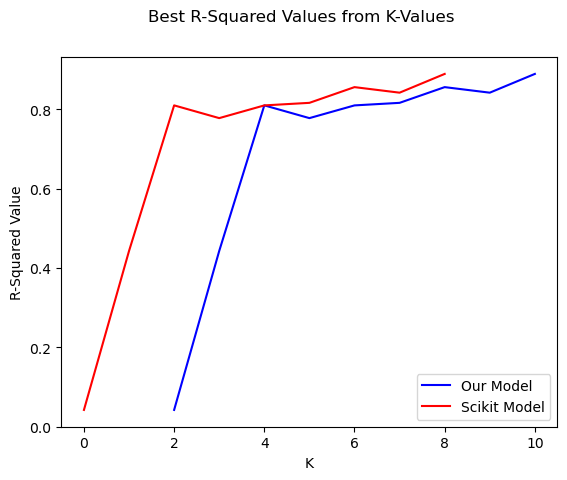

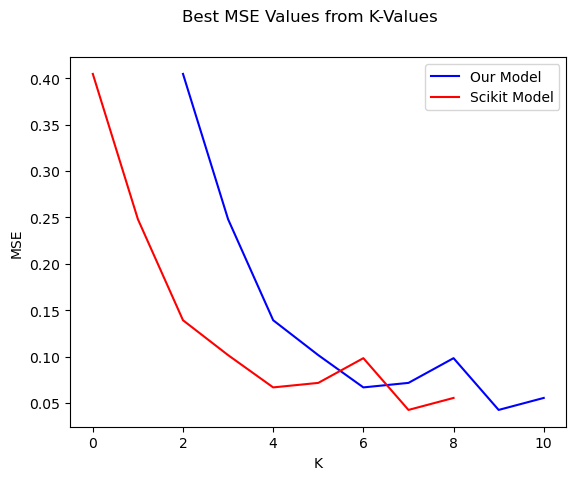

Our max r-squared was: 0.8895506371856974
Our min MSE was: 0.0425100518780296
Scikit max r-squared was: 0.8895506371857107
Scikit min MSE was: 0.0425100518780296


In [10]:
# comparing both models r-squared values
plot_results(x = [x for x in range(2, 11)],
            y1 = our_rsquared_dataset2, 
            y2 = scikit_rsquared_dataset2, 
            title = "Best R-Squared Values from K-Values", 
            xtitle = "K", 
            ytitle = "R-Squared Value", 
            ylabel1 = "Our Model", 
            ylabel2 = "Scikit Model")

# comparing both models mse values
plot_results(x = [x for x in range(2, 11)],
            y1 = our_mse_dataset2, 
            y2 = scikit_mse_dataset2, 
            title = "Best MSE Values from K-Values", 
            xtitle = "K", 
            ytitle = "MSE", 
            ylabel1 = "Our Model", 
            ylabel2 = "Scikit Model")

# printing out best results from both
print("Our max r-squared was: " + str(max(our_rsquared_dataset2)))
print("Our min MSE was: " + str(min(our_mse_dataset2)))
print("Scikit max r-squared was: " + str(max(scikit_rsquared_dataset2)))
print("Scikit min MSE was: " + str(min(our_mse_dataset2)))

**Dataset 3:  Country average temperatures, country region, country income level, and country carbon emission level per capita**

In [27]:
# Initialize lists to store metrics across different k values
scikit_mse_across_k = []
our_model_mse_across_k = []
scikit_r_squared_across_k = []
our_model_r_squared_across_k = []

x = dataset_3_data
y = dataset_3_target

# Creating the k-fold indices
for k in range(2, 11):
    folds = k_fold_indices(x, k)
    scikit_mse_k_fold = []
    our_model_mse_k_fold = []
    scikit_r_squared_k_fold = []
    our_model_r_squared_k_fold = []

    # iterating through each fold, running both models on each of them
    for fold_idx, (train_indices, test_indices) in enumerate(folds):
        # Retrieve training and testing data for this fold
        x_train, y_train = x.iloc[train_indices], y.iloc[train_indices]
        x_test, y_test = x.iloc[test_indices], y.iloc[test_indices]

        print('***** Results of scikit-learn linear regression model on dataset 3 *****')

        # Train the scikit-learn linear regression model
        model_scikit.fit(x_train, y_train)

        # Make predictions on testing set using scikit-learn model
        scikit_predictions_test = model_scikit.predict(x_test)

        # Calculate mean squared error and R-squared for scikit-learn model
        mse_scikit_test = skmetrics.mean_squared_error(y_test, scikit_predictions_test)
        r_squared_scikit_test = skmetrics.r2_score(y_test, scikit_predictions_test)
        print('Testing set mean squared error: {:.4f}'.format(mse_scikit_test))
        print('Testing set r-squared scores: {:.4f}'.format(r_squared_scikit_test))
        scikit_mse_k_fold.append(mse_scikit_test)
        scikit_r_squared_k_fold.append(r_squared_scikit_test)

        print('***** Results of our linear regression model on dataset 3 *****')

        # Train our linear regression model
        x_train_transposed = np.transpose(x_train.values)
        x_test_transposed = np.transpose(x_test.values)
        model_ours.fit(x_train_transposed, y_train)

        # Make predictions on testing set using our model
        our_predictions_test = model_ours.predict(x_test_transposed)

        # Calculate mean squared error and R-squared for our model
        mse_our_test = skmetrics.mean_squared_error(y_test, our_predictions_test)
        r_squared_our_test = skmetrics.r2_score(y_test, our_predictions_test)
        print('Testing set mean squared error: {:.4f}'.format(mse_our_test))
        print('Testing set r-squared scores: {:.4f}'.format(r_squared_our_test))
        our_model_mse_k_fold.append(mse_our_test)
        our_model_r_squared_k_fold.append(r_squared_our_test)

    # Calculate the best metrics across all folds for this k value
    scikit_mse = np.min(scikit_mse_k_fold)
    our_model_mse = np.min(our_model_mse_k_fold)
    scikit_r_squared = np.max(scikit_r_squared_k_fold)
    our_model_r_squared = np.max(our_model_r_squared_k_fold)

    scikit_mse_across_k.append(scikit_mse)
    our_model_mse_across_k.append(our_model_mse)
    scikit_r_squared_across_k.append(scikit_r_squared)
    our_model_r_squared_across_k.append(our_model_r_squared)


***** Results of scikit-learn linear regression model on dataset 3 *****
Testing set mean squared error: 7.9955
Testing set r-squared scores: -21.7194
***** Results of our linear regression model on dataset 3 *****
Testing set mean squared error: 194895724.5522
Testing set r-squared scores: -553797728.2879
***** Results of scikit-learn linear regression model on dataset 3 *****
Testing set mean squared error: 3.4272
Testing set r-squared scores: -6.0410
***** Results of our linear regression model on dataset 3 *****
Testing set mean squared error: 22648201.8652
Testing set r-squared scores: -46529768.2741
***** Results of scikit-learn linear regression model on dataset 3 *****
Testing set mean squared error: 1948.5894
Testing set r-squared scores: -6234.0368
***** Results of our linear regression model on dataset 3 *****
Testing set mean squared error: 132531.5835
Testing set r-squared scores: -424069.5153
***** Results of scikit-learn linear regression model on dataset 3 *****
Testing

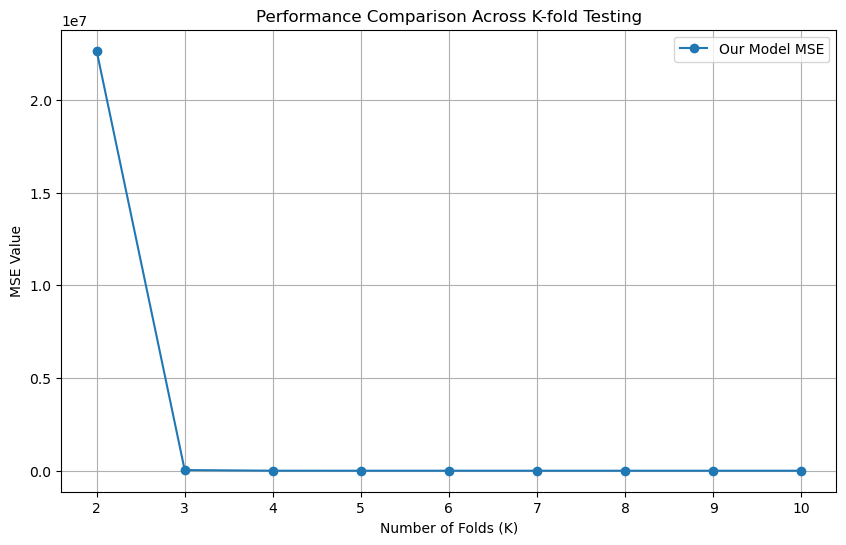

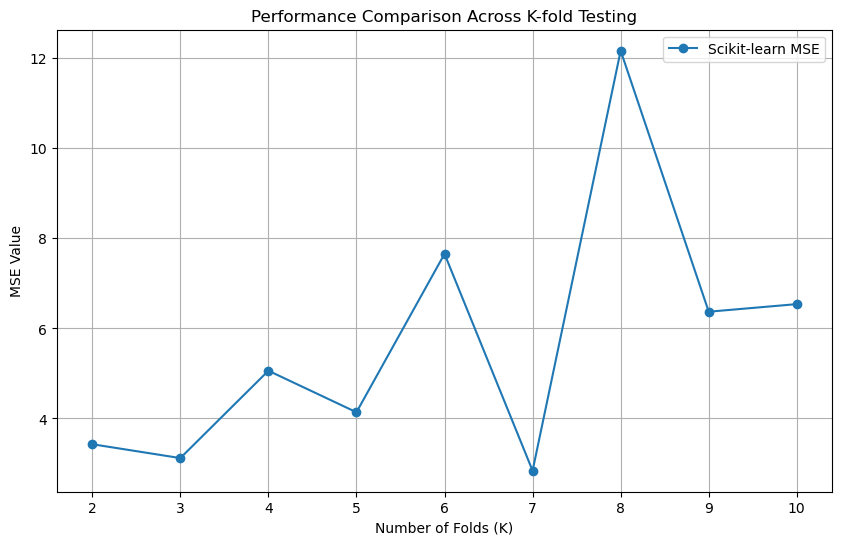

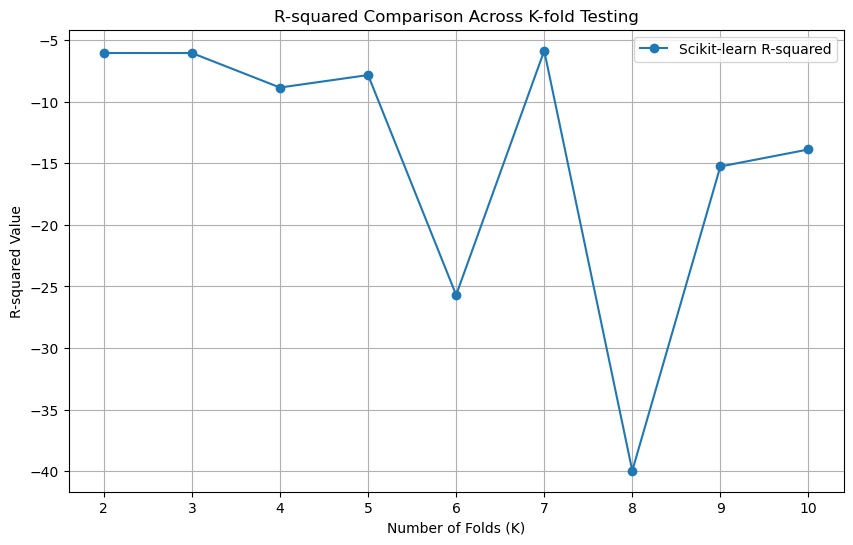

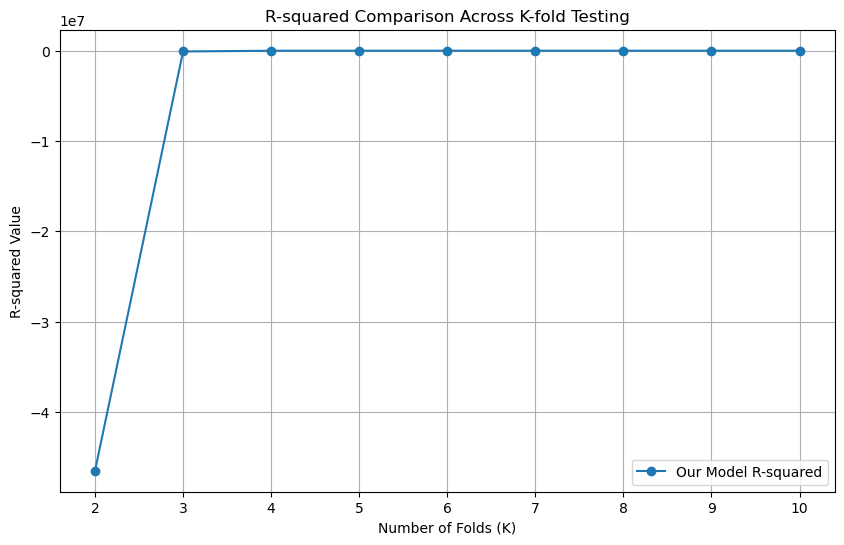

Our max r-squared was: -55.888180682660106
Our min MSE was: 34.52364600321259
Scikit max r-squared was: -5.85588034697084
Scikit min MSE was: -39.96566400755978


In [31]:
# comparing mse across both models
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), our_model_mse_across_k, marker='o', label='Our Model MSE')
plt.title('Performance Comparison Across K-fold Testing')
plt.xlabel('Number of Folds (K)')
plt.ylabel('MSE Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), scikit_mse_across_k, marker='o', label='Scikit-learn MSE')
plt.title('Performance Comparison Across K-fold Testing')
plt.xlabel('Number of Folds (K)')
plt.ylabel('MSE Value')
plt.legend()
plt.grid(True)
plt.show()

# comparing r-squared across both models
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), scikit_r_squared_across_k, marker='o', label='Scikit-learn R-squared')
plt.title('R-squared Comparison Across K-fold Testing')
plt.xlabel('Number of Folds (K)')
plt.ylabel('R-squared Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), our_model_r_squared_across_k, marker='o', label='Our Model R-squared')
plt.title('R-squared Comparison Across K-fold Testing')
plt.xlabel('Number of Folds (K)')
plt.ylabel('R-squared Value')
plt.legend()
plt.grid(True)
plt.show()

# printing out best results from both
print("Our max r-squared was: " + str(max(our_model_r_squared_across_k)))
print("Our min MSE was: " + str(min(our_model_mse_across_k)))
print("Scikit max r-squared was: " + str(max(scikit_r_squared_across_k)))
print("Scikit min MSE was: " + str(min(scikit_r_squared_across_k)))